# Optimizing YouTube Posting Strategy: A Simple Data-Driven Analysis  

*****

This notebook is an effort to presents a comprehensive analysis of YouTube video performance with the goal of identifying what factors influence engagement. Key highlights include identifying trends and patterns in the data, finding most influential features influencing view counts, and performing A/B testing to recommend posting strategies based on engagement metrics.

## Dataset  

There are several ways to collect YouTube data, including the official "YouTube Data API v3". However, to get things moving fast, this notebook uses the [Kaggle YouTube Trending Videos dataset](https://www.kaggle.com/datasets/canerkonuk/youtube-trending-videos-global). This dataset is updated daily and includes:  

- Video metadata (ID, title, description, tags, duration, etc.)
- Channel information (title, subscriber count, country, age, etc.)
- Engagement metrics (views, likes, comments)
- Trending information (trending date, trending country)

**Dataset size**: 3,389,193 records x 28 columns (roughly 6.5GB)

Now, let's go ahead!   

## En Garde

In [141]:
# Importing primary libraries.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [2]:
# Folder containing YouTube data.
data_folder_path = os.path.join(os.getcwd(), "..", "data")

# Creating dataframe.
df = pd.read_csv(os.path.join(data_folder_path, "youtube_trending_videos_global.csv"))

# Check data.
df.head()

,video_id,video_published_at,video_trending__date,video_trending_country,channel_id,video_title,video_description,video_default_thumbnail,video_category_id,video_tags,...,channel_description,channel_custom_url,channel_published_at,channel_country,channel_view_count,channel_subscriber_count,channel_have_hidden_subscribers,channel_video_count,channel_localized_title,channel_localized_description
0,bB3-CUMERIU,2024-10-11T00:00:06Z,2024.10.12,United Arab Emirates,UCNYi_zGmR519r5gYdOKLTjQ,JENNIE - Mantra (Official Music Video),Official music video for “Mantra” by JENNIE ou...,https://i.ytimg.com/vi/bB3-CUMERIU/default.jpg,Music,"JENNIE,Mantra,제니,Jennie Mantra,Jennie from Bla...",...,NaN,@jennierubyjane,2021-01-13T06:19:55.86689Z,NaN,464615150.0,11600000.0,False,43.0,JENNIE,NaN
1,5ObJt_71AYc,2024-10-11T02:59:21Z,2024.10.12,United Arab Emirates,UCzU8-lZlRfkV3nj0RzAZdrQ,CHILE vs. BRASIL [1-2] | RESUMEN | ELIMINATORI...,#Chile #Brasil #eliminatoriassudamericanas #Cr...,https://i.ytimg.com/vi/5ObJt_71AYc/default.jpg,Sports,"fútbol,pelota,gol,copa,libertadores,sudamerica...",...,Canal Oficial de la Confederación Sudamericana...,@conmebol,2014-02-19T20:24:31Z,NaN,399046746.0,1610000.0,False,4637.0,CONMEBOL,Canal Oficial de la Confederación Sudamericana...
2,zfb0whgBBA8,2024-10-11T11:07:25Z,2024.10.12,United Arab Emirates,UCgGYPnVJytkr6sVNLQ-l0zQ,تحدي الحقيبة مع ابو عبير 🔥 | سلسلتنا #2,"1,375,547 مشترك❤️\n\nـــــــــــــــــــــــــ...",https://i.ytimg.com/vi/zfb0whgBBA8/default.jpg,Gaming,"تشكيله,فيفا,فيفا20,التمت,درافت,زلاتان,ام,جي,مل...",...,صانع محتوى وانزل مقاطع بشكل غير منظم 🌚,@mrlle99,2012-08-01T16:24:26Z,Saudi Arabia,114331110.0,1380000.0,False,314.0,LLE عبدالاله,صانع محتوى وانزل مقاطع بشكل غير منظم 🌚
3,SJfoPdeOPCQ,2024-10-11T00:10:10Z,2024.10.12,United Arab Emirates,UCzU8-lZlRfkV3nj0RzAZdrQ,VENEZUELA vs. ARGENTINA [1-1] | RESUMEN | ELIM...,#Venezuela #Argentina #eliminatoriassudamerica...,https://i.ytimg.com/vi/SJfoPdeOPCQ/default.jpg,Sports,"fútbol,pelota,gol,copa,libertadores,sudamerica...",...,Canal Oficial de la Confederación Sudamericana...,@conmebol,2014-02-19T20:24:31Z,NaN,399046746.0,1610000.0,False,4637.0,CONMEBOL,Canal Oficial de la Confederación Sudamericana...
4,UVb6QOKy0bI,2024-10-09T12:30:27Z,2024.10.12,United Arab Emirates,UCOzubmwpVZI7gD0Jf7Bk3Aw,Bougainvillea Trailer | October 17 | Jyothirma...,Presenting The Official Trailer of Bougainvill...,https://i.ytimg.com/vi/UVb6QOKy0bI/default.jpg,Film & Animation,NaN,...,Official YouTube Channel Of Amal Neerad Produc...,@amalneeradproductions5264,2017-05-31T14:31:01Z,NaN,19991522.0,40600.0,False,56.0,Amal Neerad Productions,Official YouTube Channel Of Amal Neerad Produc...


In [3]:
print("Dataset rows:", df.shape[0])
print("Dataset columns:", df.shape[1])

Dataset rows: 3389193
Dataset columns: 28


## Data Preprocessing

### Removing redundant columns   
Reading the column descriptions, we can get rid of few columns that would not add much significance to our goals.

Removing the below columns (with explanation):

- video_default_thumbnail: This column has an URL of the thumbnail. For the scope of this project, can be skipped.
- channel_custom_url: Similar informtion as channel_title. Can be skipped.
- channel_localized_title: Similar information as channel_title, but in local language. Can be skipped.
- channel_localized_description: Similar information as channel_description, but in local language. Can be skipped.

In [4]:
df = df.drop(columns=["video_default_thumbnail", "channel_custom_url", "channel_localized_title", "channel_localized_description"])

### Addressing Missing Values

In [5]:
# Checking Data Types & missing values.
def check_dtypes_and_missing(df):
    return pd.DataFrame({"Columns": df.columns.to_list(), 
                         "Data Type": list(df.dtypes.values), 
                         "Missing values": list(df.isnull().sum().values),
                         "Percentage": list(df.isnull().mean().round(4) * 100)})

check_dtypes_and_missing(df)

,Columns,Data Type,Missing values,Percentage
0,video_id,object,13,0.00
1,video_published_at,object,0,0.00
2,video_trending__date,object,0,0.00
3,video_trending_country,object,8,0.00
4,channel_id,object,0,0.00
5,video_title,object,0,0.00
6,video_description,object,578065,17.06
7,video_category_id,object,2180,0.06
8,video_tags,object,1127433,33.27
9,video_duration,object,13,0.00


We see that there are a lot of missing values in some columns. And some columns have very few missing values. To get rid of missing values, we'll deal with different columns using different strategies.

In [6]:
# Removing rows with null values in object columns with less than 5% missing values.
df = df.dropna(subset=["video_id", 
                       "video_trending_country", 
                       "video_category_id", 
                       "video_duration", 
                       "video_dimension", 
                       "video_definition", 
                       "video_licensed_content", 
                       "channel_title", 
                       "channel_published_at", 
                       "channel_have_hidden_subscribers"])

In [7]:
# Let's check the result.
check_dtypes_and_missing(df)

,Columns,Data Type,Missing values,Percentage
0,video_id,object,0,0.00
1,video_published_at,object,0,0.00
2,video_trending__date,object,0,0.00
3,video_trending_country,object,0,0.00
4,channel_id,object,0,0.00
5,video_title,object,0,0.00
6,video_description,object,577821,17.06
7,video_category_id,object,0,0.00
8,video_tags,object,1126816,33.27
9,video_duration,object,0,0.00


In [8]:
# Filling null values for object columns with more than 5% nulls.
# However, I have not considered video_description & channel_description columns here.

# Reason being:
# 1) video_description: We can extract length of description & create new feature later, so better it stay untouched for now.
# 2) channel_description: Same as above.

df["video_tags"] = df["video_tags"].fillna("unknown")
df["channel_country"] = df["channel_country"].fillna("NA")

In [9]:
# Filling null values for numeric columns by imputation.
missing_ncols = ["video_view_count", "video_like_count", "video_comment_count", "channel_view_count"]

# Checking stats for better idea.
df[missing_ncols].describe()

,video_view_count,video_like_count,video_comment_count,channel_view_count
count,3.386314e+06,3.348214e+06,3.366129e+06,3.378691e+06
mean,1.429391e+07,4.173403e+05,7.395296e+03,5.460074e+09
std,2.941823e+07,8.950150e+05,2.592676e+04,1.258158e+10
min,5.299000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.067430e+05,2.138600e+04,5.750000e+02,2.632901e+08
50%,2.425038e+06,7.874200e+04,1.725000e+03,1.205799e+09
75%,1.307503e+07,3.710280e+05,4.688000e+03,4.836352e+09
max,4.075230e+08,1.090424e+07,6.009910e+05,2.995339e+11


In [10]:
# Imputing with median seems better as the data has large range.
for col in missing_ncols:
    df[col] = df[col].fillna(df[col].median())

In [11]:
# Let's check the result.
check_dtypes_and_missing(df)

,Columns,Data Type,Missing values,Percentage
0,video_id,object,0,0.00
1,video_published_at,object,0,0.00
2,video_trending__date,object,0,0.00
3,video_trending_country,object,0,0.00
4,channel_id,object,0,0.00
5,video_title,object,0,0.00
6,video_description,object,577821,17.06
7,video_category_id,object,0,0.00
8,video_tags,object,0,0.00
9,video_duration,object,0,0.00


Perfect! Another issue to be seen is that there are datetime & date type of columns with object datatype. Let's fix that.

### Fixing Date Columns

In [12]:
# Listing datetime columns & date columns.
datetime_cols = ["video_published_at", "video_trending__date", "channel_published_at"]

# Checking datatypes before conversion.
df[datetime_cols].dtypes

video_published_at      object
video_trending__date    object
channel_published_at    object
dtype: object

In [19]:
# Converting to datetime datatype.
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], format="mixed", utc=True)

In [20]:
# Check after conversion.
check_dtypes_and_missing(df)

,Columns,Data Type,Missing values,Percentage
0,video_id,object,0,0.00
1,video_published_at,"datetime64[ns, UTC]",0,0.00
2,video_trending__date,"datetime64[ns, UTC]",0,0.00
3,video_trending_country,object,0,0.00
4,channel_id,object,0,0.00
5,video_title,object,0,0.00
6,video_description,object,577821,17.06
7,video_category_id,object,0,0.00
8,video_tags,object,0,0.00
9,video_duration,object,0,0.00


In [21]:
print("Dataset rows:", df.shape[0])
print("Dataset columns:", df.shape[1])

Dataset rows: 3386987
Dataset columns: 24


In [22]:
df.head()

,video_id,video_published_at,video_trending__date,video_trending_country,channel_id,video_title,video_description,video_category_id,video_tags,video_duration,...,video_like_count,video_comment_count,channel_title,channel_description,channel_published_at,channel_country,channel_view_count,channel_subscriber_count,channel_have_hidden_subscribers,channel_video_count
0,bB3-CUMERIU,2024-10-11 00:00:06+00:00,2024-10-12 00:00:00+00:00,United Arab Emirates,UCNYi_zGmR519r5gYdOKLTjQ,JENNIE - Mantra (Official Music Video),Official music video for “Mantra” by JENNIE ou...,Music,"JENNIE,Mantra,제니,Jennie Mantra,Jennie from Bla...",PT2M28S,...,2042255.0,152933.0,JENNIE,NaN,2021-01-13 06:19:55.866890+00:00,NA,464615150.0,11600000.0,False,43.0
1,5ObJt_71AYc,2024-10-11 02:59:21+00:00,2024-10-12 00:00:00+00:00,United Arab Emirates,UCzU8-lZlRfkV3nj0RzAZdrQ,CHILE vs. BRASIL [1-2] | RESUMEN | ELIMINATORI...,#Chile #Brasil #eliminatoriassudamericanas #Cr...,Sports,"fútbol,pelota,gol,copa,libertadores,sudamerica...",PT10M8S,...,78742.0,2549.0,CONMEBOL,Canal Oficial de la Confederación Sudamericana...,2014-02-19 20:24:31+00:00,NA,399046746.0,1610000.0,False,4637.0
2,zfb0whgBBA8,2024-10-11 11:07:25+00:00,2024-10-12 00:00:00+00:00,United Arab Emirates,UCgGYPnVJytkr6sVNLQ-l0zQ,تحدي الحقيبة مع ابو عبير 🔥 | سلسلتنا #2,"1,375,547 مشترك❤️\n\nـــــــــــــــــــــــــ...",Gaming,"تشكيله,فيفا,فيفا20,التمت,درافت,زلاتان,ام,جي,مل...",PT43M24S,...,101155.0,10541.0,LLE عبدالاله,صانع محتوى وانزل مقاطع بشكل غير منظم 🌚,2012-08-01 16:24:26+00:00,Saudi Arabia,114331110.0,1380000.0,False,314.0
3,SJfoPdeOPCQ,2024-10-11 00:10:10+00:00,2024-10-12 00:00:00+00:00,United Arab Emirates,UCzU8-lZlRfkV3nj0RzAZdrQ,VENEZUELA vs. ARGENTINA [1-1] | RESUMEN | ELIM...,#Venezuela #Argentina #eliminatoriassudamerica...,Sports,"fútbol,pelota,gol,copa,libertadores,sudamerica...",PT10M9S,...,78742.0,3115.0,CONMEBOL,Canal Oficial de la Confederación Sudamericana...,2014-02-19 20:24:31+00:00,NA,399046746.0,1610000.0,False,4637.0
4,UVb6QOKy0bI,2024-10-09 12:30:27+00:00,2024-10-12 00:00:00+00:00,United Arab Emirates,UCOzubmwpVZI7gD0Jf7Bk3Aw,Bougainvillea Trailer | October 17 | Jyothirma...,Presenting The Official Trailer of Bougainvill...,Film & Animation,unknown,PT2M12S,...,67522.0,2869.0,Amal Neerad Productions,Official YouTube Channel Of Amal Neerad Produc...,2017-05-31 14:31:01+00:00,NA,19991522.0,40600.0,False,56.0


Perfect, now we can move to Feature Engineering.

## Feature Engineering

Lot of scope for experimentation here. Some of it that comes to mind is:

- After publish date, how many days it took to get trending?
- How long is the video title?
- How long is the video description? Same for channel description.
- How many tags for that video?
- video duration in seconds. Currently it is in ISO8601 format (eg., "PT10M15S" for 10 minutes and 15 seconds)
- how old is channel when video was published?
- Day & hour when the video was published.
- likes & comments count per viewer.
- likes & comments ratio.
- How big is channel, based on subscribers?

Let's try to address these one by one.

**1. After publish date, how many days it took to get trending?**

In [23]:
# For this, we can calculate days between video_published_at and video_trending__date
df["days_to_trending"] = (df["video_trending__date"] - df["video_published_at"]).dt.days

**2. How long is the video title?**

In [24]:
# We can calculate length of video_title
df["video_title_length"] = df["video_title"].apply(lambda x: len(str(x)))

**3. How long is the video description & channel description?**

In [25]:
# Same as above.
df["video_description_length"] = df["video_description"].apply(lambda x: len(str(x)) if not pd.isna(x) else 0)
df["channel_description_length"] = df["channel_description"].apply(lambda x: len(str(x)) if not pd.isna(x) else 0)

**4. How many tags for that video?**

In [32]:
# We had replaced null values with "unknown", and tags are separated by ",". 
df["video_tags_count"] = df["video_tags"].apply(lambda x: 0 if x == "unknown" else len(str(x).split(",")))

**5. Video duration in seconds.**

In [30]:
# Currently the video_duration is in ISO8601 format (eg., "PT10M15S" for 10 minutes and 15 seconds). 
# We'll make a numeric column out of it.

# Function for extracting video duration in seconds.
def convert_duration_to_sec(duration_str): 
    # Extracting digits.
    hours = re.search(r"(\d+)H", duration_str)
    minutes = re.search(r"(\d+)M", duration_str)
    seconds = re.search(r"(\d+)S", duration_str)

    # Matching.
    hours = int(hours.group(1)) if hours else 0
    minutes = int(minutes.group(1)) if minutes else 0
    seconds = int(seconds.group(1)) if seconds else 0

    # Converting to seconds.
    duration_in_seconds = hours * 3600 + minutes * 60 + seconds
    
    return duration_in_seconds

# Add video duration in seconds
df["video_duration_in_seconds"] = df["video_duration"].apply(convert_duration_to_sec)

**6. How old is channel when video was published?**

In [31]:
# For this, we can calculate difference between video_published_at & channel_published_at columns.
df["channel_age_days"] = (df["video_published_at"] - df["channel_published_at"]).dt.days

**7. Day & hour when the video was published.**

In [33]:
# Extracting day of week and hour for publishing time.
df["video_publish_day_name"] = df["video_published_at"].dt.day_name()
df["video_publish_hour"] = df["video_published_at"].dt.hour

**8. Likes & comments count per viewer.**

In [34]:
# Simple divide.
df["likes_per_view"] = df["video_like_count"] / df["video_view_count"]
df["comments_per_view"] = df["video_comment_count"] / df["video_view_count"]

**9. Likes & comments ratio.**

In [35]:
# Simple divide.
df["likes_to_comments_ratio"] = df["video_like_count"] / df["video_comment_count"]

**10. How big is channel, based on subscribers?**

In [36]:
# For this, we can define channel size categories.
df["channel_size_category"] = pd.cut(df["channel_subscriber_count"], 
                                     bins=[0, 10000, 100000, 1000000, 10000000, float("inf")],
                                     labels=["Micro", "Small", "Medium", "Large", "Mega"])

Okay, let's check the results.

In [37]:
df.head()

,video_id,video_published_at,video_trending__date,video_trending_country,channel_id,video_title,video_description,video_category_id,video_tags,video_duration,...,channel_description_length,video_tags_count,video_duration_in_seconds,channel_age_days,video_publish_day_name,video_publish_hour,likes_per_view,comments_per_view,likes_to_comments_ratio,channel_size_category
0,bB3-CUMERIU,2024-10-11 00:00:06+00:00,2024-10-12 00:00:00+00:00,United Arab Emirates,UCNYi_zGmR519r5gYdOKLTjQ,JENNIE - Mantra (Official Music Video),Official music video for “Mantra” by JENNIE ou...,Music,"JENNIE,Mantra,제니,Jennie Mantra,Jennie from Bla...",PT2M28S,...,0,17,148,1366,Friday,0,0.099451,0.007447,13.353920,Mega
1,5ObJt_71AYc,2024-10-11 02:59:21+00:00,2024-10-12 00:00:00+00:00,United Arab Emirates,UCzU8-lZlRfkV3nj0RzAZdrQ,CHILE vs. BRASIL [1-2] | RESUMEN | ELIMINATORI...,#Chile #Brasil #eliminatoriassudamericanas #Cr...,Sports,"fútbol,pelota,gol,copa,libertadores,sudamerica...",PT10M8S,...,145,29,608,3886,Friday,2,0.019854,0.000643,30.891330,Large
2,zfb0whgBBA8,2024-10-11 11:07:25+00:00,2024-10-12 00:00:00+00:00,United Arab Emirates,UCgGYPnVJytkr6sVNLQ-l0zQ,تحدي الحقيبة مع ابو عبير 🔥 | سلسلتنا #2,"1,375,547 مشترك❤️\n\nـــــــــــــــــــــــــ...",Gaming,"تشكيله,فيفا,فيفا20,التمت,درافت,زلاتان,ام,جي,مل...",PT43M24S,...,38,55,2604,4453,Friday,11,0.118564,0.012355,9.596338,Large
3,SJfoPdeOPCQ,2024-10-11 00:10:10+00:00,2024-10-12 00:00:00+00:00,United Arab Emirates,UCzU8-lZlRfkV3nj0RzAZdrQ,VENEZUELA vs. ARGENTINA [1-1] | RESUMEN | ELIM...,#Venezuela #Argentina #eliminatoriassudamerica...,Sports,"fútbol,pelota,gol,copa,libertadores,sudamerica...",PT10M9S,...,145,28,609,3886,Friday,0,0.020949,0.000829,25.278331,Large
4,UVb6QOKy0bI,2024-10-09 12:30:27+00:00,2024-10-12 00:00:00+00:00,United Arab Emirates,UCOzubmwpVZI7gD0Jf7Bk3Aw,Bougainvillea Trailer | October 17 | Jyothirma...,Presenting The Official Trailer of Bougainvill...,Film & Animation,unknown,PT2M12S,...,53,0,132,2687,Wednesday,12,0.039026,0.001658,23.535030,Small


In [39]:
df[["days_to_trending", 
    "video_title_length", 
    "video_description_length", 
    "channel_description_length", 
    "video_tags_count", 
    "video_duration_in_seconds", 
    "channel_age_days", 
    "video_publish_day_name", 
    "video_publish_hour", 
    "likes_per_view", 
    "comments_per_view", 
    "likes_to_comments_ratio", 
    "channel_size_category"]].head()

,days_to_trending,video_title_length,video_description_length,channel_description_length,video_tags_count,video_duration_in_seconds,channel_age_days,video_publish_day_name,video_publish_hour,likes_per_view,comments_per_view,likes_to_comments_ratio,channel_size_category
0,0,38,304,0,17,148,1366,Friday,0,0.099451,0.007447,13.353920,Mega
1,0,72,319,145,29,608,3886,Friday,2,0.019854,0.000643,30.891330,Large
2,0,39,1132,38,55,2604,4453,Friday,11,0.118564,0.012355,9.596338,Large
3,0,79,929,145,28,609,3886,Friday,0,0.020949,0.000829,25.278331,Large
4,2,96,929,53,0,132,2687,Wednesday,12,0.039026,0.001658,23.535030,Small


Looks good! Before moving to predictions and A/B Testing, let's do exploratory data analysis to understand the trends.

## EDA

**1. Basic Descriptive Statistics**

In [52]:
# Function for good visuals of section titles.
def section_title(title):
    seq_len = 100
    print("\n{0}\n{2}{1}\n{0}\n".format("="*seq_len, title, " "*int(((seq_len-len(title))/2))))

# Basic statistics
section_title("Basic Descriptive Stats")
df.describe()


                                      Basic Descriptive Stats



,video_view_count,video_like_count,video_comment_count,channel_view_count,channel_subscriber_count,channel_video_count,days_to_trending,video_title_length,video_description_length,channel_description_length,video_tags_count,video_duration_in_seconds,channel_age_days,video_publish_hour,likes_per_view,comments_per_view,likes_to_comments_ratio
count,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386987e+06,3.386877e+06
mean,1.429156e+07,4.134642e+05,7.360376e+03,5.449653e+09,1.333815e+07,5.583728e+03,1.114713e+01,5.026125e+01,6.838994e+02,2.584705e+02,1.370732e+01,1.030082e+03,3.048151e+03,1.297966e+01,3.824060e-02,1.920055e-03,inf
std,2.941578e+07,8.906061e+05,2.585061e+04,1.256792e+10,3.959661e+07,2.439812e+04,8.610936e+00,2.297302e+01,7.937480e+02,2.766096e+02,1.461972e+01,2.491262e+03,1.864505e+03,6.370186e+00,4.298471e-02,3.440014e-03,NaN
min,5.299000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.069530e+05,2.174800e+04,5.800000e+02,2.644379e+08,8.320000e+05,2.470000e+02,4.000000e+00,3.300000e+01,1.190000e+02,5.400000e+01,0.000000e+00,4.400000e+01,1.536000e+03,9.000000e+00,1.734761e-02,1.385146e-04,1.465657e+01
50%,2.425038e+06,7.874200e+04,1.725000e+03,1.205799e+09,3.290000e+06,7.570000e+02,9.000000e+00,4.600000e+01,4.480000e+02,1.470000e+02,1.000000e+01,2.220000e+02,2.978000e+03,1.400000e+01,3.022707e-02,9.178775e-04,3.109556e+01
75%,1.307100e+07,3.637830e+05,4.651000e+03,4.816567e+09,1.130000e+07,1.866000e+03,1.700000e+01,6.500000e+01,9.230000e+02,3.700000e+02,2.400000e+01,1.170000e+03,4.386000e+03,1.800000e+01,4.927404e-02,2.413955e-03,2.204000e+02
max,4.075230e+08,1.090424e+07,6.009910e+05,2.995339e+11,4.020000e+08,6.204610e+05,3.700000e+01,1.000000e+02,5.000000e+03,1.498000e+03,1.310000e+02,5.026400e+04,2.020000e+04,2.300000e+01,5.325443e+00,5.104542e-01,inf


**2. Trending Countries**


                                     Trending Videos by Country



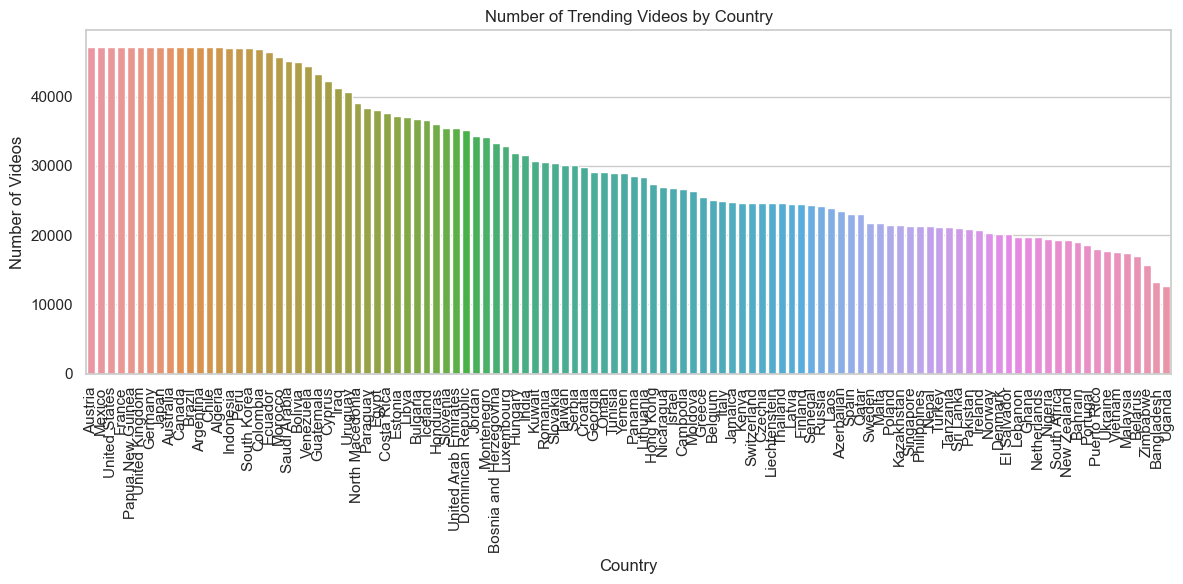

In [65]:
# Trending by country
section_title("Trending Videos by Country")
country_counts = df["video_trending_country"].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title("Number of Trending Videos by Country")
plt.xlabel("Country")
plt.ylabel("Number of Videos")
plt.xticks(rotation=90)
plt.tight_layout()

**3. Video Categories**


                                     Video Categories Analysis



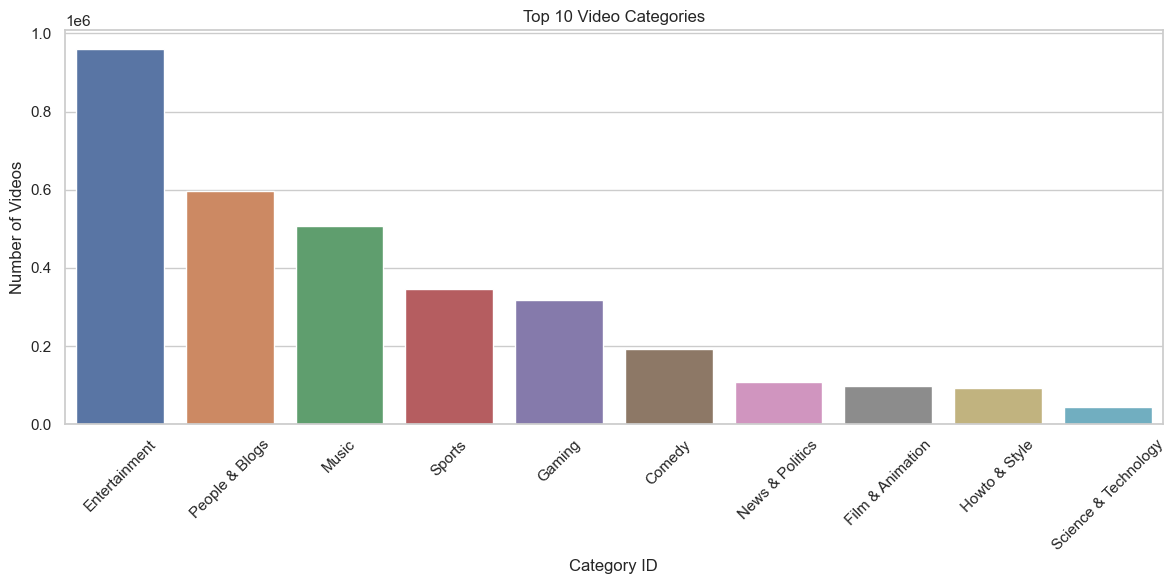

In [67]:
# Video Categories
section_title("Video Categories Analysis")
category_counts = df["video_category_id"].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Top 10 Video Categories")
plt.xlabel("Category ID")
plt.ylabel("Number of Videos")
plt.xticks(rotation=45)
plt.tight_layout()

- Entertainment dominates the trending space, followed by People & Blogs and Music.

- Sports, Gaming, and Comedy form the middle tier.

- Niche categories like News, Film & Animation, How-to, and Science & Tech are significantly less represented among top-trending videos.

**4. Channel Analysis**


                                          Channel Analysis



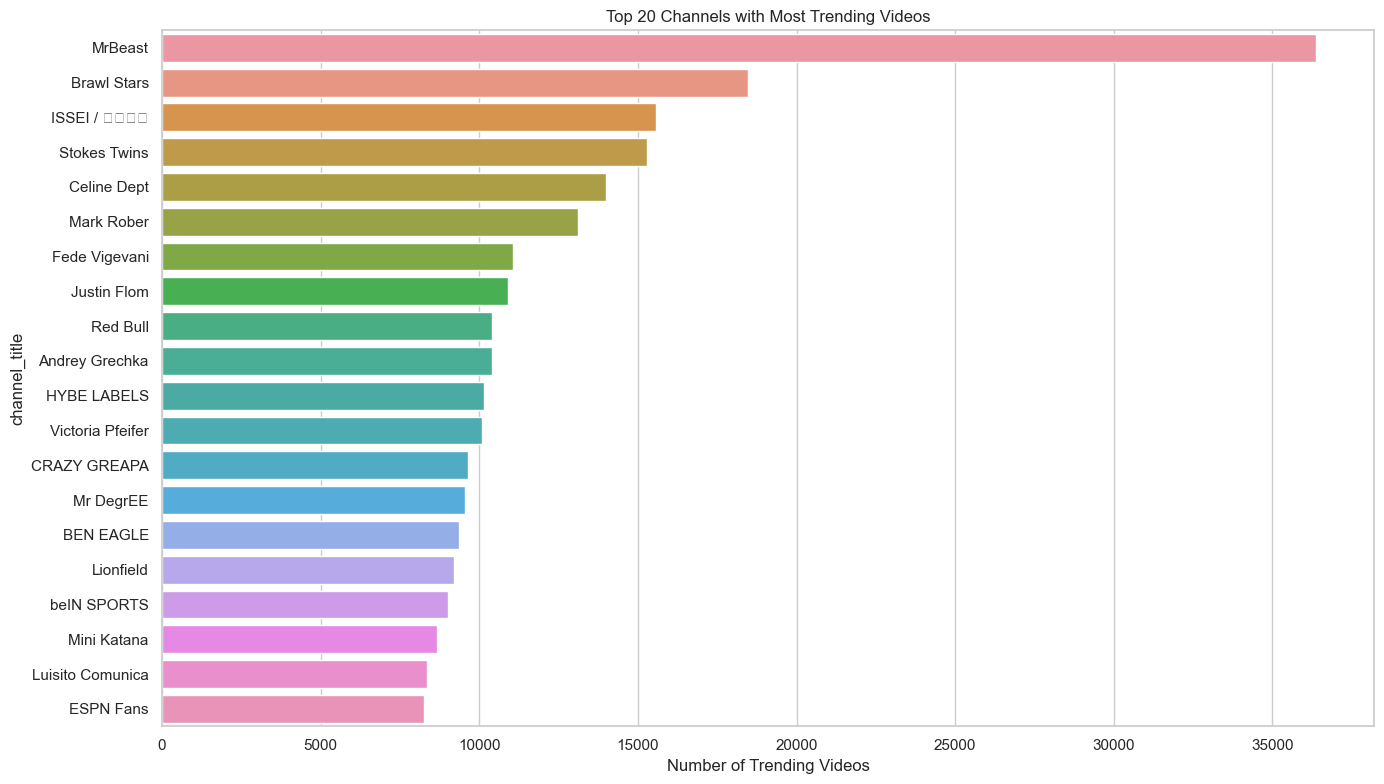

In [71]:
section_title("Channel Analysis")
top_channels = df.groupby('channel_title').size().sort_values(ascending=False).head(20)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_channels.values, y=top_channels.index)
plt.title("Top 20 Channels with Most Trending Videos")
plt.xlabel("Number of Trending Videos")
plt.tight_layout()

**5. Publishing Patterns: Day of Week and Hour of Day for Trending Videos**


                                        Publishing Patterns



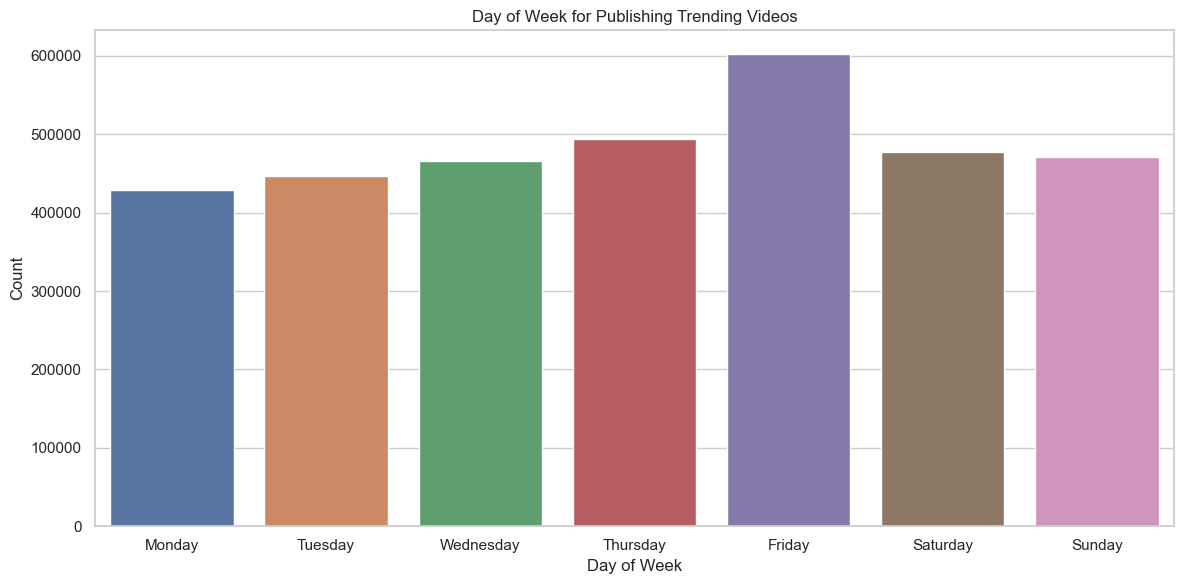

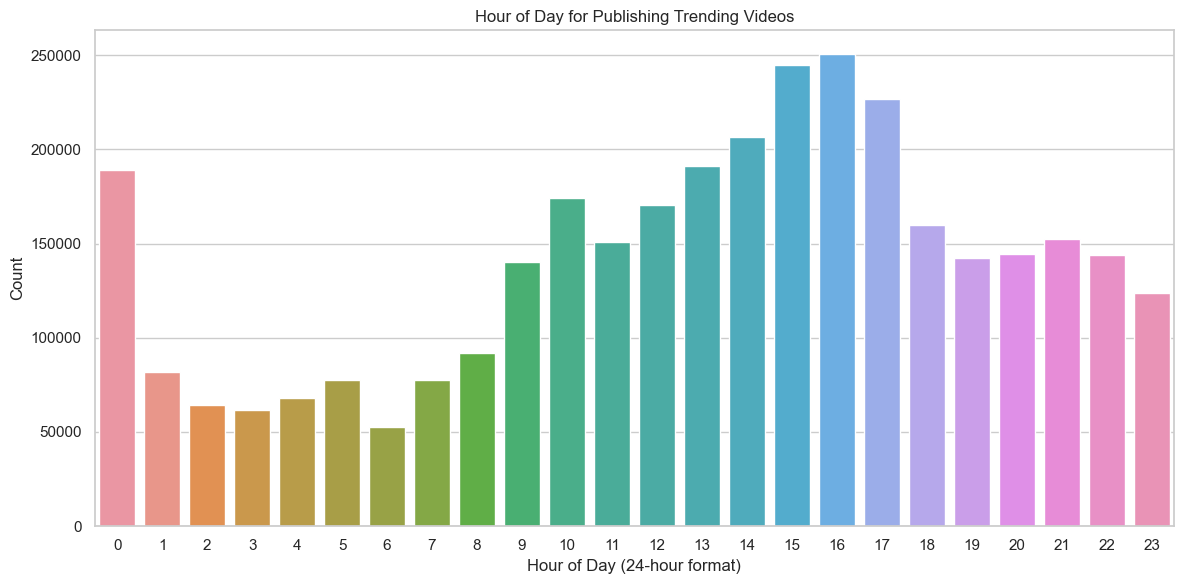

In [75]:
section_title("Publishing Patterns")
plt.figure(figsize=(12, 6))
sns.countplot(x="video_publish_day_name", data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Day of Week for Publishing Trending Videos")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.tight_layout()

plt.figure(figsize=(12, 6))
sns.countplot(x="video_publish_hour", data=df)
plt.title("Hour of Day for Publishing Trending Videos")
plt.xlabel("Hour of Day (24-hour format)")
plt.ylabel("Count")
plt.tight_layout()

- Most videos are published between 2 PM and 5 PM, peaking around 3–4 PM.

- There’s also a decent volume at midnight (0 hour)—possibly scheduled uploads.

- Mornings (2–9 AM) see relatively fewer uploads that go viral.

**6. Video Duration Analysis**


                                      Video Duration Analysis



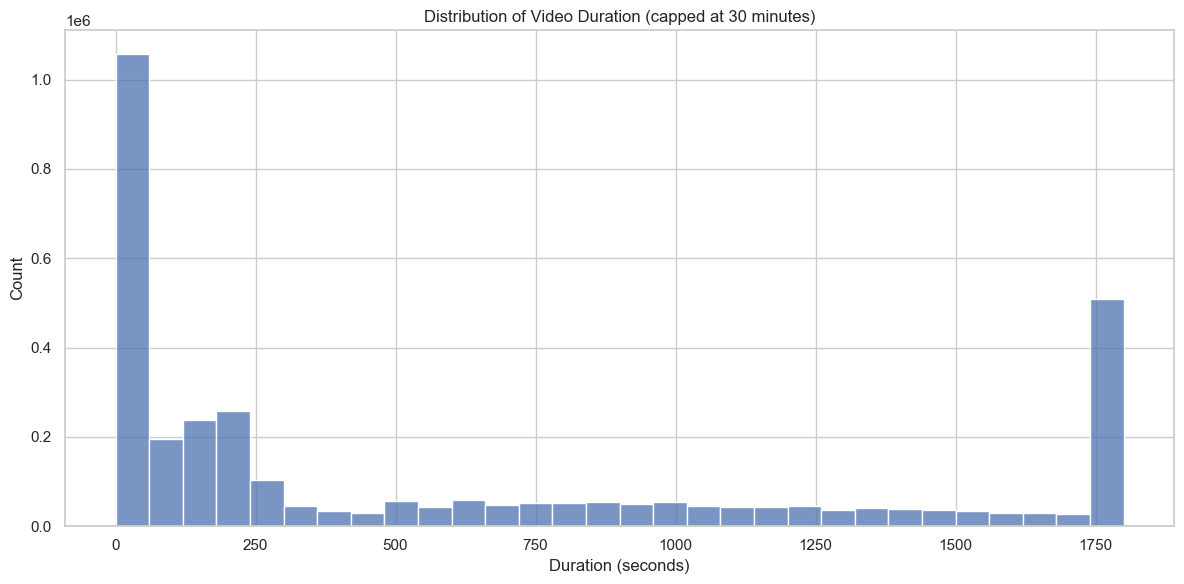

In [78]:
section_title("Video Duration Analysis")
plt.figure(figsize=(12, 6))
sns.histplot(df["video_duration_in_seconds"].clip(0, 1800), bins=30)
plt.title("Distribution of Video Duration (capped at 30 minutes)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.tight_layout()

These plots give us an idea about the distribution and trend across few features. Now let's try to identify main correaltion between the features.

## Correlation Analysis


                                        Correlation Analysis



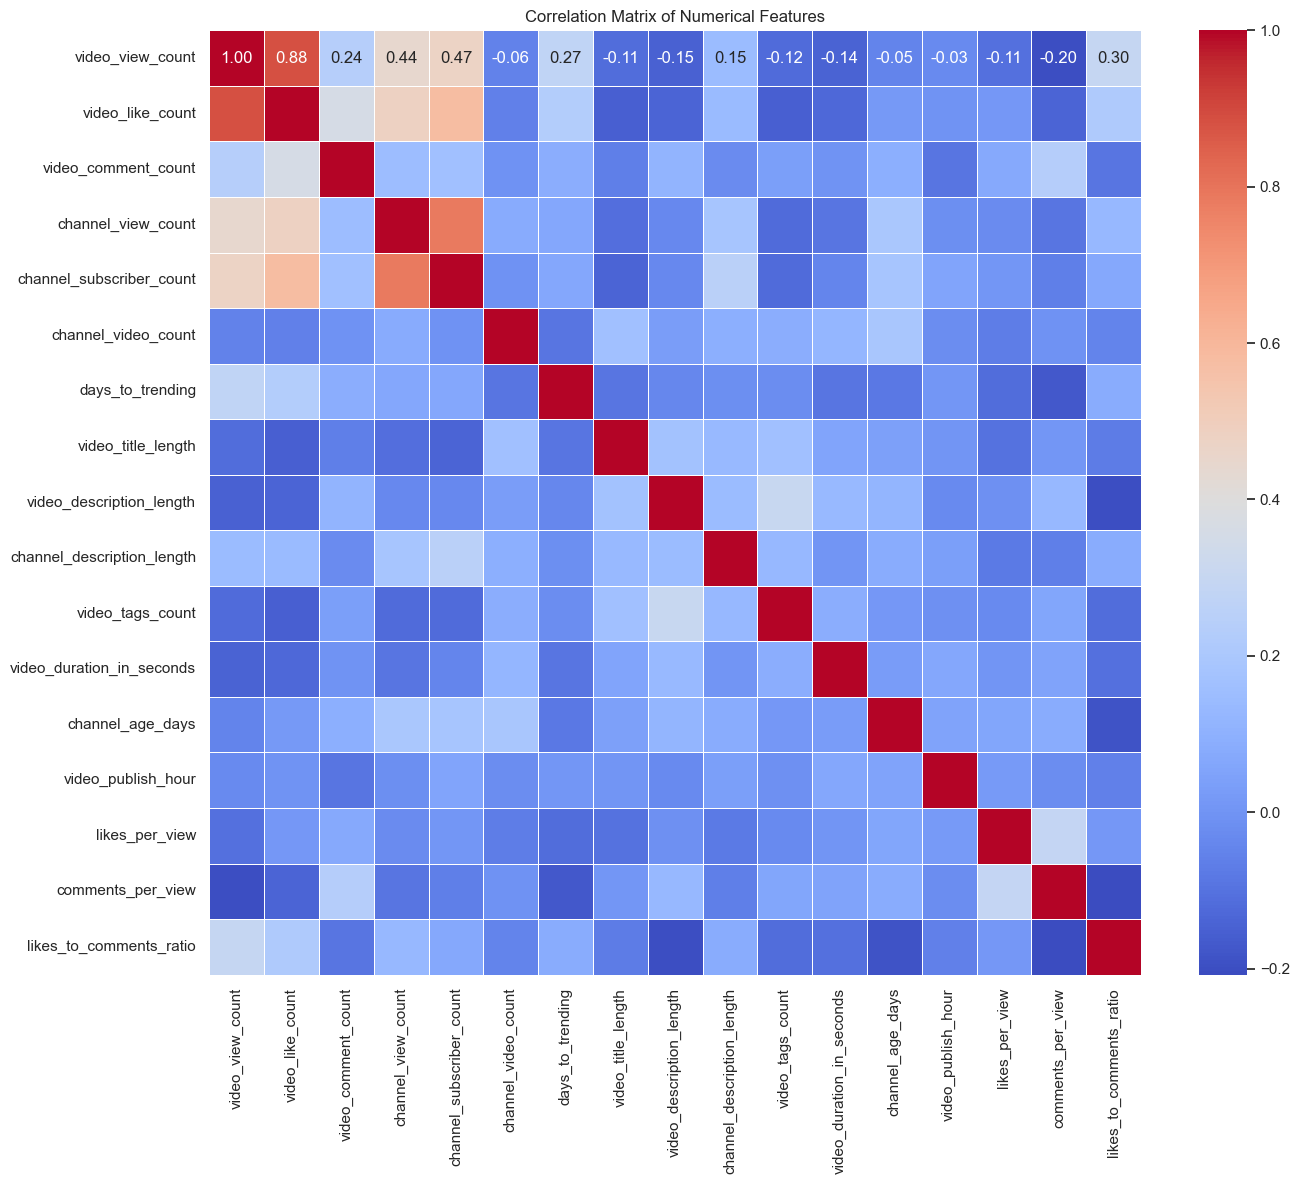

In [85]:
# Considering numeric columns for correlation.
numeric_cols = df.select_dtypes(include="number").columns.to_list()

# Creating correlation matrix.
section_title("Correlation Analysis")
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()

**Strong Correlations**
1. Views, Likes, and Subscribers - There's a very strong correlation (0.88) between video views and likes. Channel subscriber count is also moderately correlated with both video views and likes.
2. Channel Metrics - Channel view count and subscriber count have a strong correlation, which makes sense as popular channels tend to have both high subscribers and views.
    
**Engagement Metrics**
1. Comments vs Views/Likes - Interestingly, comment count has a much weaker correlation with views and likes than views and likes have with each other. This suggests that high viewership doesn't necessarily translate to high comment engagement.
2. Engagement Ratios - The `likes_per_view` and `comments_per_view` metrics have a moderate positive correlation with each other, suggesting that videos that get people to like are somewhat more likely to get them to comment as well.
    
**Content Characteristics**
1. Video Duration - Video duration shows slightly negative correlations with views (-0.14) and likes, suggesting that shorter videos might perform slightly better in terms of overall engagement.
2. Tag Count and Description Length - These have a moderate positive correlation, indicating that creators who use more tags also tend to write longer descriptions.
    
**Time Factors**
1. Days to Trending - This has a modest positive correlation with views (0.27), suggesting that videos that take longer to trend might accumulate more views in that process.
     
**Weak or No Correlations**
1. Channel Age - Channel age has weak correlations with most metrics, suggesting that older channels don't necessarily perform better just because of their age.
2. Title Length - Shows very weak correlations with engagement metrics, suggesting that title length alone isn't strongly related to performance.

Let's move towards prediction models to assess what factors influence the target features.

## Predictive Analytics

### Predicting View Counts

In [86]:
# Checking for columns to consider as features.
check_dtypes_and_missing(df)

,Columns,Data Type,Missing values,Percentage
0,video_id,object,0,0.00
1,video_published_at,"datetime64[ns, UTC]",0,0.00
2,video_trending__date,"datetime64[ns, UTC]",0,0.00
3,video_trending_country,object,0,0.00
4,channel_id,object,0,0.00
5,video_title,object,0,0.00
6,video_description,object,577821,17.06
7,video_category_id,object,0,0.00
8,video_tags,object,0,0.00
9,video_duration,object,0,0.00



                                       Predicting View Count

RMSE: 1035692.0447073348


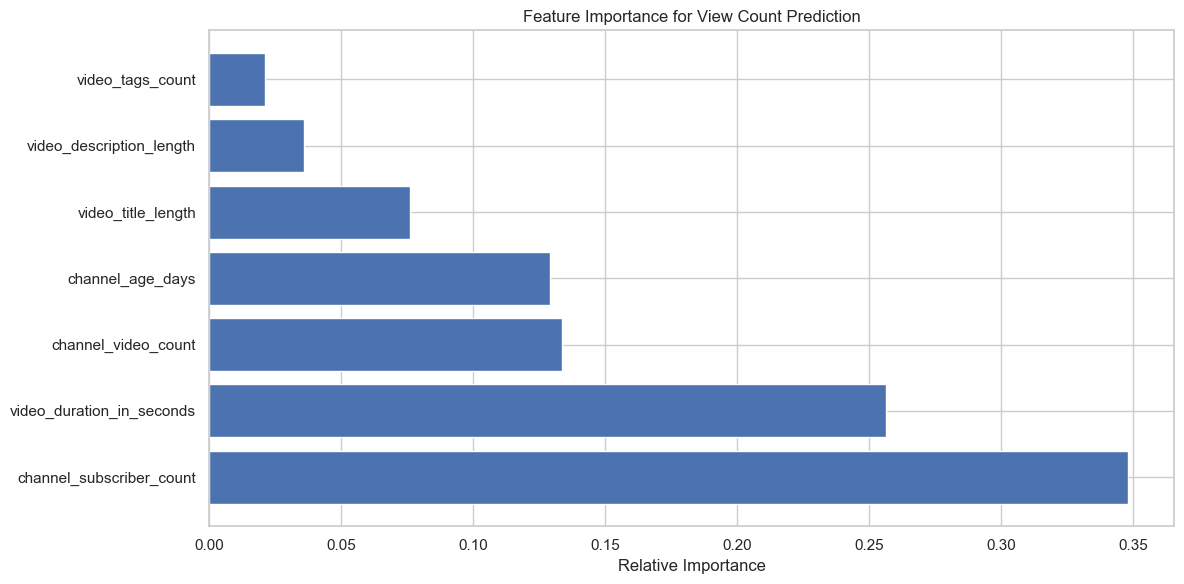

In [100]:
section_title("Predicting View Count")

# Preparing features and target.
feature_cols = ["video_duration_in_seconds", 
                "channel_subscriber_count", 
                "channel_video_count", 
                "video_tags_count", 
                "video_title_length", 
                "video_description_length", 
                "channel_age_days"]

X = df[feature_cols]
y = df["video_view_count"]

# Spliting data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a random forest regressor.
model_views = RandomForestRegressor(n_estimators=100, random_state=42)
model_views.fit(X_train, y_train)

# Making predictions.
y_pred = model_views.predict(X_test)

# Evaluating.
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Feature importance calculation.
importances = model_views.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotting the scores.
plt.figure(figsize=(12, 6))
plt.title("Feature Importance for View Count Prediction")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.tight_layout()

### Key Findings

1. **Most Important Feature**: Channel subscriber count has the highest relative importance (approximately 0.35) in predicting view counts, indicating that established channels with larger audiences tend to get more views regardless of other factors.
       
        
2. **Secondary Important Features**:
    - Video duration in seconds (~0.25 importance)
    - Channel video count (~0.12 importance)
    - Channel age in days (~0.12 importance)     
      
        
3. **Less Impactful Features**:
    - Video title length (~0.07)
    - Video description length (~0.03)
    - Video tags count count (~0.02)

### Insights & Recommendations

1. **Audience Building is Critical**: Since channel subscriber count dominates, content creators should focus on growing their subscriber base through consistent, quality content.

2. **Video Length Matters**: The significant importance of video duration suggests viewers prefer certain lengths of content (either longer or shorter depending on platform norms).

3. **Channel History Helps**: Both channel age and total video count contribute meaningfully, showing that persistence and content volume build credibility.

4. **Metadata is Secondary**: Title, description and tags have relatively minor impact, suggesting SEO optimization may be less important than fundamental content quality and channel factors.

### Note  
This is a baseline model that uses RandomForestRegressor for the sole purpose of obtaining feature importance scores. Further optimization can definitely be done in the following areas to improve the performance and make predictions with higher accuracy.  

Scope for improving performance:

- More columns as features (Object columns as label-encoded or one-hot values)
- Scaled features (Norm or standardized)
- Adjusting decision tree depth with `max_depth`
- Use of XGBoost or Deep Learning methods for better predictions  

Perfect! Now we can move towards the main part of A/B Testing.

## A/B Testing to Assess Engagement Metrics

### 1. Morning vs Evening Posting

We will perform a simple A/B test to do posting Time Analysis. Comparing performance of posting times (morning vs evening) uploads to find how it affects engagement metrics.

In [116]:
# Engagement Metrics to compare.
metrics = ["video_view_count", "video_like_count", "video_comment_count", "likes_per_view", "comments_per_view"]

# Calculating comparison.
results = {
            "metric": [],
            "morning_mean": [],
            "evening_mean": [],
            "difference": [],
            "percent_change": [],
            "p_value": [],
            "significant": []}

# To define posting time as morning or evening, we will create a new feature.
df["time_category"] = df.apply(lambda x: "morning" if 8 <= x["video_publish_hour"] <= 12 else ("evening" if 17 <= x["video_publish_hour"] <= 21 else "other"), axis=1)
df["time_category"].value_counts()

time_category
other      1833455
evening     825774
morning     727758
Name: count, dtype: int64

In [117]:
# Creating separate dataframes for morning & evening posts.
morning_posts_df = df[df["time_category"] == "morning"]
evening_posts_df = df[df["time_category"] == "evening"]

In [119]:
# Metric Calculation.
for metric in metrics:
    morning_mean = morning_posts_df[metric].mean()
    evening_mean = evening_posts_df[metric].mean()
    difference = evening_mean - morning_mean
    percent_change = (difference / morning_mean * 100) if morning_mean != 0 else 0

    # Taking metric values for statistical test.
    morning_vals = morning_posts_df[metric].dropna()
    evening_vals = evening_posts_df[metric].dropna()
    
    # Performing Welch’s t-test (handles unequal variance).
    t_stat, p_value = ttest_ind(evening_vals, morning_vals, equal_var=False)    

    # Considering p < 0.05 as significant.
    is_significant = p_value < 0.05
        
    results["metric"].append(metric)
    results["morning_mean"].append(morning_mean)
    results["evening_mean"].append(evening_mean)
    results["difference"].append(difference)
    results["percent_change"].append(percent_change)
    results["p_value"].append(p_value)
    results["significant"].append(is_significant)
    
results_df = pd.DataFrame(results)

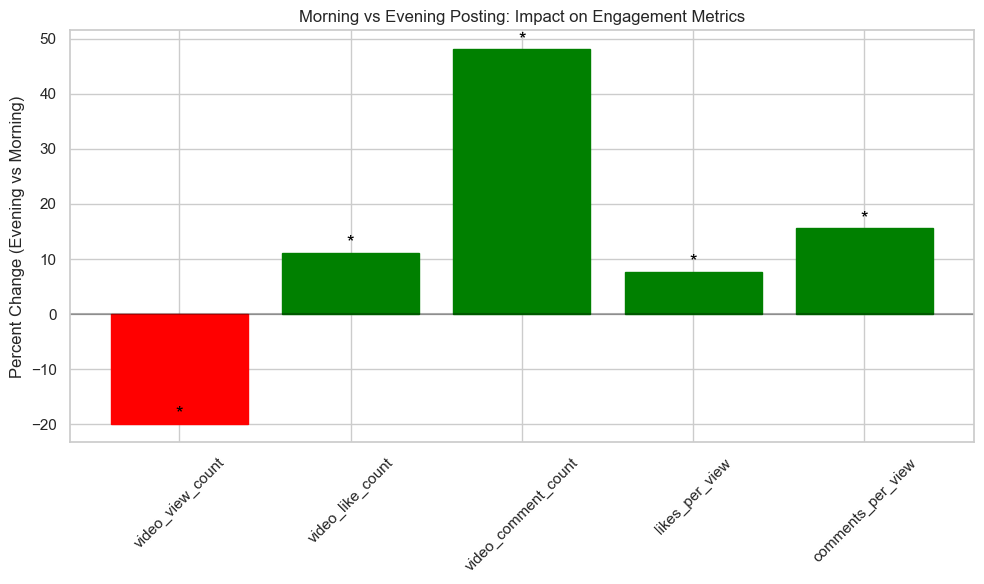

In [122]:
# Creating visualization.
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df["metric"], results_df["percent_change"])
    
# Color bars based on positive/negative change
for i, bar in enumerate(bars):
    bar.set_color("green" if results_df["percent_change"].iloc[i] > 0 else "red")
    if results_df["significant"].iloc[i]:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), '*', 
                 ha="center", va="bottom", fontsize=14, color="black")
    
plt.axhline(y=0, color="black", linestyle="-", alpha=0.3)
plt.title("Morning vs Evening Posting: Impact on Engagement Metrics")
plt.ylabel("Percent Change (Evening vs Morning)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [130]:
section_title("Key Findings")
for _, row in results_df.iterrows():
    # Showing significant differences.
    if abs(row["significant"]) == True:  
        better_time = "Evening posts" if row["percent_change"] > 0 else "Morning posts"
        print("- {}: {} performs {}% better".format(row["metric"], better_time, round(abs(row["percent_change"]), 1)))

section_title("A/B Testting Results")
results_df


                                            Key Findings

- video_view_count: Morning posts performs 19.9% better
- video_like_count: Evening posts performs 11.2% better
- video_comment_count: Evening posts performs 48.1% better
- likes_per_view: Evening posts performs 7.7% better
- comments_per_view: Evening posts performs 15.6% better

                                        A/B Testting Results



,metric,morning_mean,evening_mean,difference,percent_change,p_value,significant
0,video_view_count,1.568064e+07,1.256498e+07,-3.115666e+06,-19.869506,0.000000e+00,True
1,video_like_count,3.923897e+05,4.362561e+05,4.386645e+04,11.179308,6.036470e-181,True
2,video_comment_count,3.826302e+03,5.666537e+03,1.840235e+03,48.094340,0.000000e+00,True
3,likes_per_view,3.710599e-02,3.996982e-02,2.863823e-03,7.717952,0.000000e+00,True
4,comments_per_view,1.687673e-03,1.951194e-03,2.635215e-04,15.614487,0.000000e+00,True


### Insights   

- Evening posts may get less reach on average.
- Though fewer views, evening viewers are more engaged (more like counts).
- Evening posts spark more discussions or viewer reactions.
- Engagement efficiency is clearly higher in the evening.

### Recommendation

- Post videos in the evening (5–9 PM) if your goal is engagement quality (likes/comments per view).
- If reach (total views) is the primary goal, morning may be better.
- For further scope we can also try this trend across content types.

### 2. Weekday vs Weekend Posting

Let's perform similar testing for weekday & weekend posting.

In [135]:
# We will create a category column for weekday & weekend.
df["day_category"] = df["video_publish_day_name"].apply(lambda x: "weekend" if x in ["Saturday", "Sunday"] else "weekday")
df[["video_publish_day_name", "day_category"]].head(10)

,video_publish_day_name,day_category
0,Friday,weekday
1,Friday,weekday
2,Friday,weekday
3,Friday,weekday
4,Wednesday,weekday
5,Saturday,weekend
6,Wednesday,weekday
7,Friday,weekday
8,Thursday,weekday
9,Thursday,weekday


In [136]:
df["day_category"].value_counts()

day_category
weekday    2437731
weekend     949256
Name: count, dtype: int64

In [137]:
# Creating separate dataframes.
weekday_posts_df = df[df["day_category"] == "weekday"]
weekend_posts_df = df[df["day_category"] == "weekend"]

# Calculating comparison.
results = {
            "metric": [],
            "morning_mean": [],
            "evening_mean": [],
            "difference": [],
            "percent_change": [],
            "p_value": [],
            "significant": []
}

# Metric Calculation.
for metric in metrics:
    weekday_mean = weekday_posts_df[metric].mean()
    weekend_mean = weekend_posts_df[metric].mean()
    difference = weekend_mean - weekday_mean
    percent_change = (difference / weekday_mean * 100) if weekday_mean != 0 else 0

    # Taking metric values for statistical test.
    weekday_vals = weekday_posts_df[metric].dropna()
    weekend_vals = weekend_posts_df[metric].dropna()
    
    # Performing Welch’s t-test (handles unequal variance).
    t_stat, p_value = ttest_ind(weekend_vals, weekday_vals, equal_var=False)    

    # Considering p < 0.05 as significant.
    is_significant = p_value < 0.05
        
    results["metric"].append(metric)
    results["morning_mean"].append(weekday_mean)
    results["evening_mean"].append(weekend_mean)
    results["difference"].append(difference)
    results["percent_change"].append(percent_change)
    results["p_value"].append(p_value)
    results["significant"].append(is_significant)
    
results_df = pd.DataFrame(results)

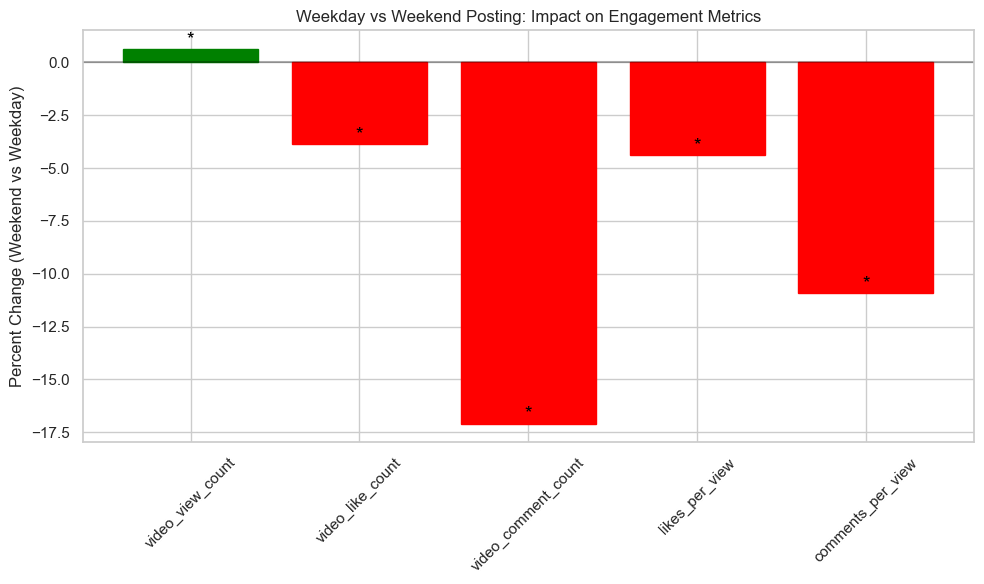

In [138]:
# Creating visualization.
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df["metric"], results_df["percent_change"])
    
# Color bars based on positive/negative change
for i, bar in enumerate(bars):
    bar.set_color("green" if results_df["percent_change"].iloc[i] > 0 else "red")
    if results_df["significant"].iloc[i]:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), '*', 
                 ha="center", va="bottom", fontsize=14, color="black")
    
plt.axhline(y=0, color="black", linestyle="-", alpha=0.3)
plt.title("Weekday vs Weekend Posting: Impact on Engagement Metrics")
plt.ylabel("Percent Change (Weekend vs Weekday)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [140]:
section_title("Key Findings")
for _, row in results_df.iterrows():
    # Showing significant differences.
    if abs(row["significant"]) == True:  
        better_time = "Weekend posts" if row["percent_change"] > 0 else "Weekday posts"
        print("- {}: {} performs {}% better".format(row["metric"], better_time, round(abs(row["percent_change"]), 1)))

section_title("A/B Testting Results")
results_df


                                            Key Findings

- video_view_count: Weekend posts performs 0.6% better
- video_like_count: Weekday posts performs 3.9% better
- video_comment_count: Weekday posts performs 17.1% better
- likes_per_view: Weekday posts performs 4.4% better
- comments_per_view: Weekday posts performs 10.9% better

                                        A/B Testting Results



,metric,morning_mean,evening_mean,difference,percent_change,p_value,significant
0,video_view_count,1.426669e+07,1.435542e+07,88729.386179,0.621934,1.190610e-02,True
1,video_like_count,4.180170e+05,4.017723e+05,-16244.781982,-3.886153,2.486545e-53,True
2,video_comment_count,7.730736e+03,6.409277e+03,-1321.458581,-17.093568,0.000000e+00,True
3,likes_per_view,3.871559e-02,3.702082e-02,-0.001695,-4.377498,2.563779e-255,True
4,comments_per_view,1.980735e-03,1.764224e-03,-0.000217,-10.930835,0.000000e+00,True


### Insights   

- More people watching on weekends, likely due to free time.
- Viewers might be less inclined to engage on weekends.
- Weekday audience is more interactive.
- Even with similar views, weekend engagement is shallow.

### Recommendation

- Target weekdays (Mon–Fri) for high-engagement posts.
- Consider posting less critical or awareness-focused content on weekends.
- For further scope we can also test weekday splits (early week vs late week) for more refinement.

*****